# Kr analysis (run 3389 short Z)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import copy
import time
import glob
print("Running on ", time.asctime())

import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Thu Mar 30 09:05:25 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/run3389_shortZ/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()


def subhist(data1, data2, bins, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    y1, x1 = np.histogram(data1, bins)
    y2, x2 = np.histogram(data2, bins, normed=True)
    y2 = y2 * np.sum(y1)
    h1 = plt.bar(x1[:-1], y1     , np.diff(x1), label="Kr")
    h2 = plt.bar(x2[:-1], y1 - y2, np.diff(x2), label="Kr - bkg")

    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/data/3389/"

In [5]:
ifiles  = glob.glob(os.path.expandvars("$IC_DATA/*.h5"))
print("# files:", len(ifiles))

# files: 2997


### Define event class

In [6]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []
        self.S1t   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []
        self.S2t   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.T     = -1
        self.ok    = False

### Define dataset class

In [7]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [8]:
#@timefunc
def fill_evts(s1s, s2s, sis, evts_out, times, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = 0
        evt.nS2 = 0

        s1time = 0
        for peak, (t, e) in s1.items():
            sel  = e > 0.5
            t, e = t[sel], e[sel]
            if t.size < 5:
                continue
            evt.nS1 += 1
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]
            evt.S1t.append(s1time)
        
        s2time = 0
        for peak, (t, e) in s2.items():
            w = width(t, to_mus=True)
            if w>20:
                continue
            evt.nS2 += 1
            evt.S2w.append(w)
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]
            evt.S2t.append(s2time)
            
            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.T  = times[i]
        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        with tb.open_file(ifile) as h5f:
            times = h5f.root.Run.events.cols.timestamp[:] * 1e-3
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, times - np.min(times), ifile)
    return Dataset(evts_out)


# Read data

In [ ]:
full = build_dataset(ifiles[:200])

/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.000_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.001_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.002_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.003_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.004_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.005_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.006_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.007_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.008_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.009_3389.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.010_3389.root.h5 163

# S2 Energy

Time spent in _create_attrs: 0.9542930126190186 s
Time spent in _create_attrs: 1.09505295753479 s


/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:119: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


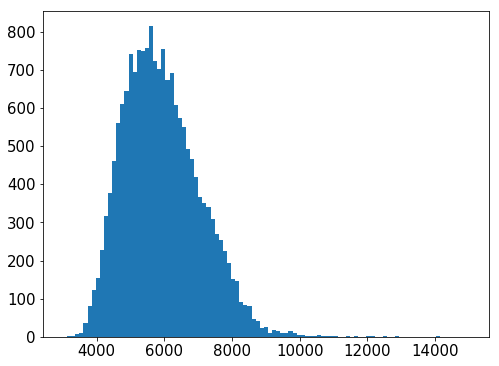

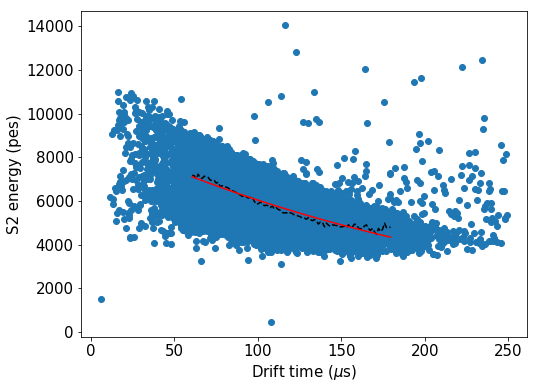

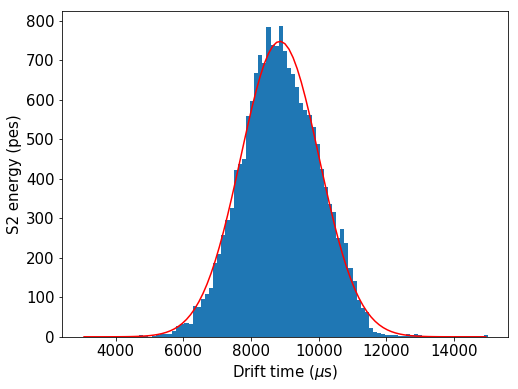

In [54]:
data = full[full.ok]
data = data[data.Z < 250]
#data = data[data.R < 100]

z = flat(data.Z)
E = flat(data.S2i)
S = flat(data.S1i)

Ebins = np.linspace(3e3, 15e3, 100)
hist(E, Ebins)
scatter(z, E)
x, y, _ = fitf.profileX(z, E, 100, (60, 180))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.expo, x, y, (1e4, -1e2))
plt.plot(x, f.fn(x), fitOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

zcorr = f.fn
Ecorr = E * zcorr(np.min(z))/zcorr(z)

y, x, _ = hist(Ecorr, Ebins)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
#plt.text(4e3, 300, "{:.3f}")
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [46]:
from operator import itemgetter
E, Z = zip(*sorted([
(66423, 203),
(26242, 403),
(12822, 560),
(98999, 111),
(27890, 559),
(18941, 558),
(31588,  57),
(80994,  43),
(134876, 49),
(67984,  77)], key=itemgetter(1)))


[ 99469.41412532   -366.11990721]


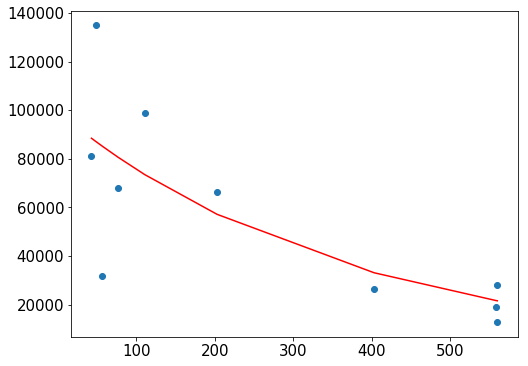

In [47]:
plt.scatter(Z, E)
f = fitf.fit(fitf.expo, Z, E, (6e4, -1e3))
plt.plot(Z, f.fn(Z), fitOpt)
print(f.values)

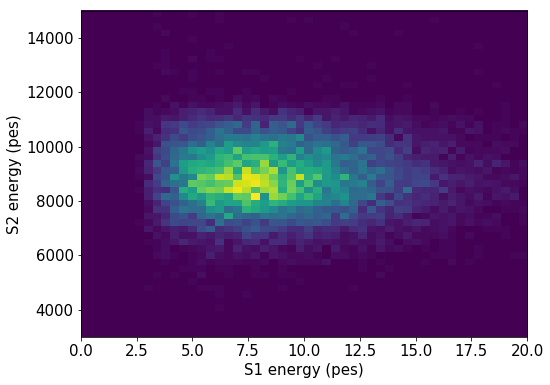

In [55]:
hist2d(S, Ecorr, 50, range=((0, 20),(3e3, 15e3)))
labels("S1 energy (pes)", "S2 energy (pes)")

## One S2

Time spent in _create_attrs: 7.4185309410095215 s
Time spent in _create_attrs: 0.4359889030456543 s


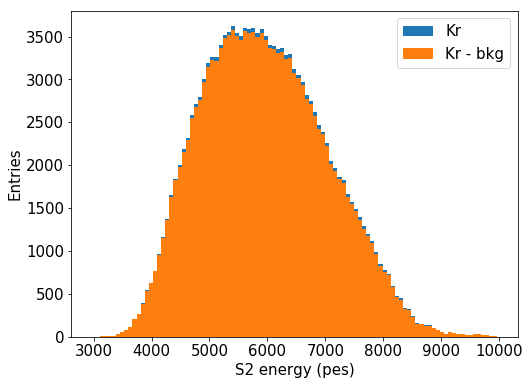

In [63]:
data = full[full.nS1 == 1]
bkg  = bkgd[bkgd.nS1 == 1]

subhist(flat(data.S2i), flat(bkg.S2i), np.linspace(3e3, 1e4, 100))
labels("S2 energy (pes)", "Entries")

# One S1 one S2

Time spent in _create_attrs: 5.543844938278198 s
Time spent in _create_attrs: 0.2961881160736084 s


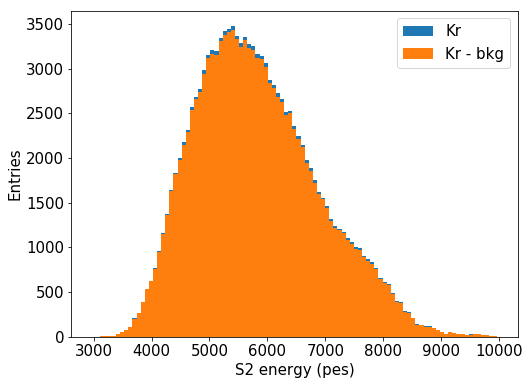

In [64]:
data = full[full.ok]
bkg  = bkgd[bkgd.ok]

subhist(flat(data.S2i), flat(bkg.S2i), np.linspace(3e3, 1e4, 100))
labels("S2 energy (pes)", "Entries")

## One S1 one S2 fiducialized

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Time spent in _create_attrs: 2.0745599269866943 s
Time spent in _create_attrs: 0.036334991455078125 s


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


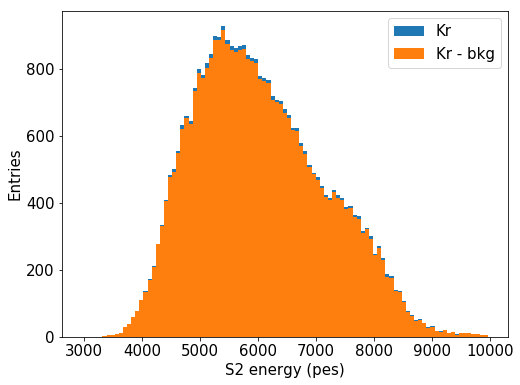

In [65]:
data = full[full.ok & (full.R < 100)]
bkg  = bkgd[bkgd.ok & (bkgd.R < 100)]

subhist(flat(data.S2i), flat(bkg.S2i), np.linspace(3e3, 1e4, 100))
labels("S2 energy (pes)", "Entries")

## One S1 one S2 fiducialized Z > 300 µs

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


Time spent in _create_attrs: 0.035964012145996094 s
Time spent in _create_attrs: 0.0008969306945800781 s


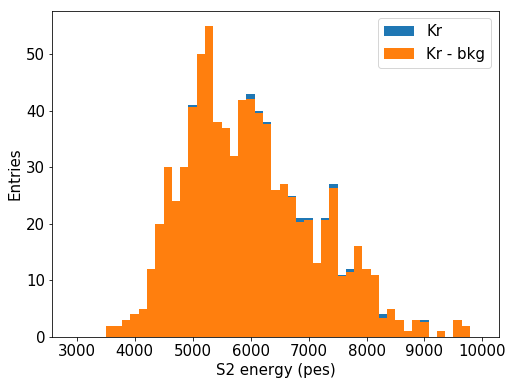

In [66]:
data = full[full.ok & (full.R < 100) & flat(full.Z > 300)]
bkg  = bkgd[bkgd.ok & (bkgd.R < 100) & flat(bkgd.Z > 300)]

subhist(flat(data.S2i), flat(bkg.S2i), np.linspace(3e3, 1e4, 50))
labels("S2 energy (pes)", "Entries")